<a href="https://colab.research.google.com/github/liuyixin-louis/dl_learning/blob/master/BP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 无框架

In [0]:
# 无框架
# https://blog.csdn.net/weixin_41722370/article/details/83590276
# 反向传播b的梯度计算用


from sklearn import datasets
from sklearn.model_selection import train_test_split
# 加载sklearn自带的mnist数据
digits = datasets.load_digits()
# 数据集包含1797个手写体数字的图片，图片大小为8*8
# 数字大小0～9，也就是说有这是个10分类问题
images = digits.images
targets = digits.target
print(("dataset shape is: "), images.shape)
# 将数据分为训练数据和测试数据（20%）
X_train,X_test,y_train,y_test = train_test_split(images , targets , test_size=0.2 , random_state=0)
num_training = 1137
num_validation = 300
num_test = y_test.shape[0]
# 将训练集再分为训练集和验证集
mask = list(range(num_training, num_training + num_validation))
X_val = X_train[mask]
y_val = y_train[mask]
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]
print("the number of train: ", num_training)
print("the number of test: ", num_test)
print("the number of validation: ", num_validation)
# 将每个数字8*8的像素矩阵转化为64*1的向量
X_train = X_train.reshape(num_training, -1)
X_val = X_val.reshape(num_validation, -1)
X_test = X_test.reshape(num_test, -1)
print("training data shape: ", X_train.shape)
print("validation data shape: ", X_val.shape)
print("test data shape: ", X_test.shape)

# 定义神经网络的参数
# 定义超参
input_size = 64
hidden_size = 30
num_classes = 10
# 为了之后使用的方便，我将参数初始化，计算loss，训练，预测的过程都定义在一个名为network的类中
import numpy as np
import matplotlib.pyplot as plt
class network(object):
    # 初始化参数,将W,b保存在名为params的字典中
    # W随机初始化，b初始化为零
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    # 定义损失函数，里面包含了前向传播的实现过程
    def loss(self, X, y=None, reg=0.0):
        # 先讲各个参数都提取出来
        W1 = self.params['W1']
        b1 = self.params['b1']
        W2 = self.params['W2']
        b2 = self.params['b2']
        N, D = X.shape
        # 前向传播
        # hidden的实现
        hidden = np.dot(X, W1) + b1
        # relu:max(0, x)
        hidden = np.maximum(0,hidden)
        # 算输出y
        y2 = np.dot(hidden, W2) + b2
        #if y == None:
          #  return y2
        # loss 计算
        loss = None
        loss = -y2[range(N), y].sum() + np.log(np.exp(y2).sum(axis = 1)).sum()
        # print (loss)
        loss = loss / N + 0.5 * reg * (np.sum(W1 * W1) + np.sum(W2 * W2))

        # 反向传播
        # 首先定义一个grads的字典，存放各个可训练参数的梯度
        grads = {}
        # 按照计算图，先计算dscore
        # 先对y2取对数
        exp = np.exp(y2)
        # 求每行个元素的和，之后用每行各个元素除上该行的和
        dscore = exp / exp.sum(axis = 1, keepdims = True)
        # 对label（即y）对应的元素减1
        dscore[range(N),y] -= 1
        # 别忘了还要除输入样本的个数
        dscore = dscore/N 

        # print(dscore.shape)
        grads['b2'] = np.sum(dscore, axis=0)
        # print(grads['b2'].shape)
        grads['W2'] = np.dot(hidden.T, dscore)+ reg * W2
        # dhidden
        dhidden = np.dot(dscore, W2.T)
        # 因为加了relu激活函数，随意要讲XW1 + b1 <0对应的dihidden元素归0
        dhidden[(np.dot(X, W1)+b1)<0] = 0
        grads['b1'] = np.sum(dhidden, axis=0)
        grads['W1'] = np.dot(X.T, dhidden) + reg * W1
        return loss, grads


    # 训练神经网络，使用了随机梯度下降，和学习率衰减的技巧
    def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
        # 查看有有多少个训练样本，并检查按照设定的batch大小每个epoch需要迭代多少次
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # 使用随机梯度下降优化可训练参数
        # 把训练过程中得到的loss和准确率信息存起来方便查看并解决问题
        loss_history = []
        train_acc_history = []
        val_acc_history = []
        # 迭代numz_iters次，每次只随机选择一个batch来训练样本
        for it in range(num_iters):
            X_batch = None
            y_batch = None
            indices = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[indices]
            y_batch = y[indices]
            # 用当前的batch训练数据来得到loss 和grad
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            # 记录这次迭代的损失大小
            loss_history.append(loss)
            self.params['W1'] -=  learning_rate * grads['W1']
            self.params['b1'] -=  learning_rate * grads['b1']
            self.params['W2'] -=  learning_rate * grads['W2']
            self.params['b2'] -=  learning_rate * grads['b2']
            # 如果你选择了可视化训练过程，那么会显示每次迭代产生的loss
            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

           # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # 每个epoch结束，衰减一下学习率
                learning_rate *= learning_rate_decay

        return {
            'loss_history': loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history,
        }

    def predict(self, X):
    
        y_pred = None
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
        scores = np.dot(hidden_layer, W2) + b2
        y_pred = np.argmax(scores, axis = 1)
        return y_pred

net = network(input_size, hidden_size, num_classes)
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=5000, batch_size=200,
            learning_rate=0.01, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

test_acc = (net.predict(X_test) == y_test).mean()
print('test accuracy: ', test_acc)

dataset shape is:  (1797, 8, 8)
the number of train:  1137
the number of test:  360
the number of validation:  300
training data shape:  (1137, 64)
validation data shape:  (300, 64)
test data shape:  (360, 64)
iteration 0 / 5000: loss 2.302588
iteration 100 / 5000: loss 2.301870
iteration 200 / 5000: loss 2.214278
iteration 300 / 5000: loss 1.272267
iteration 400 / 5000: loss 0.975817
iteration 500 / 5000: loss 0.862598
iteration 600 / 5000: loss 0.816536
iteration 700 / 5000: loss 0.819364
iteration 800 / 5000: loss 0.817833
iteration 900 / 5000: loss 0.806645
iteration 1000 / 5000: loss 0.770617
iteration 1100 / 5000: loss 0.788922
iteration 1200 / 5000: loss 0.704431
iteration 1300 / 5000: loss 0.755838
iteration 1400 / 5000: loss 0.781189
iteration 1500 / 5000: loss 0.766308
iteration 1600 / 5000: loss 0.776953
iteration 1700 / 5000: loss 0.749965
iteration 1800 / 5000: loss 0.756050
iteration 1900 / 5000: loss 0.812253
iteration 2000 / 5000: loss 0.720129
iteration 2100 / 5000: lo

# tf

In [0]:
import tensorflow as tf 
from  tensorflow.examples.tutorials.mnist  import  input_data
import numpy as np 

mnist = input_data.read_data_sets('./data/', one_hot = True)

num_classes = 10  # 输出大小
input_size = 784  # 输入大小
hidden_units_size = 30  # 隐藏层节点数量
batch_size = 100
training_iterations = 10000

X = tf.placeholder(tf.float32, shape = [None, input_size])
Y = tf.placeholder(tf.float32, shape = [None, num_classes])

W1 = tf.Variable(tf.random_normal ([input_size, hidden_units_size], stddev = 0.1))
B1 = tf.Variable(tf.constant (0.1), [hidden_units_size])
W2 = tf.Variable(tf.random_normal ([hidden_units_size, num_classes], stddev = 0.1))
B2 = tf.Variable(tf.constant (0.1), [num_classes])

hidden_opt = tf.matmul(X, W1) + B1  # 输入层到隐藏层正向传播
hidden_opt = tf.nn.relu(hidden_opt)  # 激活函数，用于计算节点输出值
final_opt = tf.matmul(hidden_opt, W2) + B2  # 隐藏层到输出层正向传播


# 对输出层计算交叉熵损失
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=final_opt))
# 梯度下降算法，这里使用了反向传播算法用于修改权重，减小损失
opt = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
# 初始化变量
init = tf.global_variables_initializer()
# 计算准确率
correct_prediction =tf.equal (tf.argmax (Y, 1), tf.argmax(final_opt, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

sess = tf.Session ()
sess.run (init)
for i in range (training_iterations) :
    batch = mnist.train.next_batch (batch_size)
    batch_input = batch[0]
    batch_labels = batch[1]
    # 训练
    training_loss = sess.run ([opt, loss], feed_dict = {X: batch_input, Y: batch_labels})
    if i % 1000 == 0 :
        train_accuracy = accuracy.eval (session = sess, feed_dict = {X: batch_input,Y: batch_labels})
        print ("step : %d, training accuracy = %g " % (i, train_accuracy))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/mo

# pytorch


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
epoch: 0, Train Loss: 0.518364, Train Acc: 0.832006, Eval Loss: 0.219871, Eval Acc: 0.931962
epoch: 1, Train Loss: 0.167449, Train Acc: 0.947778, Eval Loss: 0.115401, Eval Acc: 0.962520
epoch: 2, Train Loss: 0.118990, Train Acc: 0.962687, Eval Loss: 0.109879, Eval Acc: 0.964794
epoch: 3, Train Loss: 0.092852, Train Acc: 0.970832, Eval Loss: 0.208004, Eval Acc: 0.930083
epoch: 4, Train Loss: 0.075283, Train Acc: 0.976196, Eval Loss: 0.113856, Eval Acc: 0.964201
epoch: 5, Train Loss: 0.063886, Train Acc: 0.979777, Eval Loss: 0.085412, Eval Acc: 0.972805
epoch: 6, Train Loss: 0.052322, Train Acc: 0.983525, Eval Loss: 0.073619, Eval Acc: 0.977947
epoch: 7, Train Loss: 0.043718, Train Acc: 0.985774, Eval Loss: 0.064607, Eval Acc: 0.980123
epoch: 8, Train Loss: 0.039122, Train Acc: 0.987323, Eval Loss: 0.082386, Eval Acc: 0.975672
epoch: 9, Train Loss: 0.032520, Train Acc: 0.989489, Eval Loss: 0.193

Text(0.5, 1.0, 'test acc')

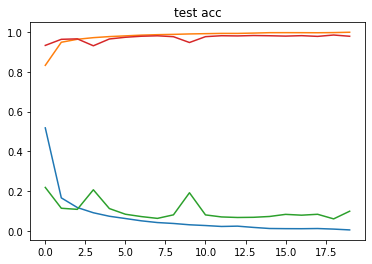

In [0]:
#-*- coding: utf-8 -*

"""
Created on Fri Jul 27 17:47:03 2018

@author: Administrator
"""
import numpy as np
import torch
from torchvision.datasets import mnist # 导入 pytorch 内置的 mnist 数据

from torch import nn
from torch.autograd import Variable
# 使用内置函数下载 mnist 数据集

#标准化
def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x
#准备数据
train_set = mnist.MNIST('./data', train=True, transform=data_tf, download=True) # 重新载入数据集，申明定义的数据变换
test_set = mnist.MNIST('./data', train=False, transform=data_tf, download=True)
a, a_label = train_set[0]#a为训练数据第一个的像素点（数据），a_label为训练数据第一个的标签
#print(a.shape)
#print(a_label)
from torch.utils.data import DataLoader
# 使用 pytorch 自带的 DataLoader 定义一个数据迭代器，也就是将数据进行排序标号，shuffle也就是打乱数据
train_data = DataLoader(train_set, batch_size=64, shuffle=True)#训练数据
test_data = DataLoader(test_set, batch_size=128, shuffle=False)#测试数据
a, a_label = next(iter(train_data))
# 打印出一个批次的数据大小
#print(a.shape)
#print(a_label.shape)
# 使用 Sequential 定义 4 层神经网络
net = nn.Sequential(
    nn.Linear(784, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)
#net
# 定义 loss 函数
criterion = nn.CrossEntropyLoss()#定义交叉熵损失函数
optimizer = torch.optim.SGD(net.parameters(), 1e-1) # 使用随机梯度下降，学习率 0.1
# 开始训练，定义空列表进而存储后边训练得到的数据
losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(20):
    train_loss = 0
    train_acc = 0
    net.train()
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    net.eval() # 将模型改为预测模式
    for im, label in test_data:
        im = Variable(im)#torch中训练需要将其封装即Variable，此处封装像素即784
        label = Variable(label)#此处为标签
        out = net(im)#经网络输出的结果
        loss = criterion(out, label)#得到误差
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)#得到出现最大值的位置，也就是预测得到的数即0—9
        num_correct = (pred == label).sum().item()#判断是否预测正确
        acc = num_correct / im.shape[0]#计算准确率
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))
import matplotlib.pyplot as plt
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
plt.plot(np.arange(len(acces)), acces)
plt.title('train acc')
plt.plot(np.arange(len(eval_losses)), eval_losses)
plt.title('test loss')
plt.plot(np.arange(len(eval_acces)), eval_acces)
plt.title('test acc')


# keras

## 1

In [0]:
from keras.models import Sequential #导入模型
from keras.layers.core import Dense #导入常用层
train_x,train_y #训练集
test_x,text_y #测试集
model=Sequential() #初始化模型
model.add(Dense(3,input_shape=(32,),activation='sigmoid'，init='uniform'))) #添加一个隐含层，注：只是第一个隐含层需指定input_dim
model.add(Dense(1,activation='sigmoid')) #添加输出层
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])  # 编译，指定目标函数与优化方法
model.fit(train_x,train_y ) # 模型训练
model.evaluate(test_x,text_y ) #模型测试

## 2


In [11]:
import os
from tensorflow.examples.tutorials.mnist import *
from keras.models import *
from keras.layers import *
 
# 屏蔽waring信息
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
 
"""----------加载mnist数据集-------------"""
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
 
 
"""----------配置网络模型----------------"""
# 配置网络结构
model=Sequential()
 
# 第一隐藏层的配置：输入784，输出100
model.add(Dense(100,input_dim=784))
model.add(Activation("relu"))
model.add(Dropout(0.5))
 
# 第二隐藏层的配置：输入100，输出100
model.add(Dense(100))
model.add(Activation("relu"))
model.add(Dropout(0.5))
 
# 输出层的配置：输入100，输出10，用了softmax的输出层结构
model.add(Dense(10))
model.add(Activation("softmax"))
 
# 编译模型，指明代价函数和更新方法
model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
 
"""----------训练模型--------------------"""
print("training starts.....")
model.fit(trX,trY,epochs=20,batch_size=20)
 
"""----------评估模型--------------------"""
# 用测试集去评估模型的准确度
accuracy=model.evaluate(teX,teY,batch_size=20)
print('\nTest accuracy:',accuracy[1])
 
"""----------模型存储--------------------"""
save_model(model,'my_model')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
import os
import cv2
import numpy as np
from keras.models import load_model
 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
 
"""---------载入已经训练好的模型---------"""
new_model = load_model('my_model')
 
"""---------用opencv载入一张待测图片-----"""
# 载入图片
src = cv2.imread('4.png')
cv2.imshow("待测图片", src)
 
# 将图片转化为28*28的灰度图
src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
dst = cv2.resize(src, (28, 28), interpolation=cv2.INTER_CUBIC)
 
# 将灰度图转化为1*784的能够输入的网络的数组
picture = np.zeros((1, 784))
for i in range(0, 28):
    for j in range(0, 28):
        picture[0][28 * i + j] = (255 - dst[i][j])
 
# 用模型进行预测
y = new_model.predict(picture)
result = np.argmax(y)
print("待测的数字是：", result)
 
cv2.waitKey(20170731)

## 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, input_dim=2, kernel_initializer="uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/100
16/16 [==============================] - 0s 10ms/step - loss: 0.9499
Epoch 2/100
16/16 [==============================] - 0s 558us/step - loss: 0.9346
Epoch 3/100
16/16 [==============================] - 0s 525us/step - loss: 0.9217
Epoch 4/100
16/16 [==============================] - 0s 910us/step - loss: 0.9109
Epoch 5/100
16/16 [==============================] - 0s 679us/step - loss: 0.9063
Epoch 6/100
16/16 [==============================] - 0s 666us/step - loss: 0.8986
Epoch 7/100
16/16 [==============================] - 0s 657us/step - loss: 0.8920
Epoch 8/100
16/16 [==============================] - 0s 568us/step - loss: 0.8841
Epoch 9/100
16/16 [==============================] - 0s 519us/step - loss: 0.8811
Epoch 10/100
16/16 [==============================] - 0s 848us/step - loss: 0.8733
Epoch 11/100
16/16 [==============================] - 0s 684us/step - loss: 0.8646
Epoch 12/100
16/16 [==============================] - 0s 667us/step - loss: 0.8590
Epoch 13/100
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_s

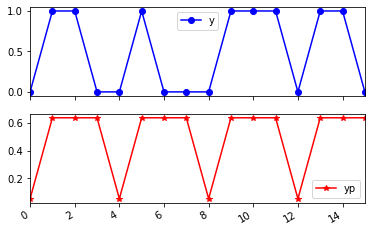

In [10]:
# https://blog.csdn.net/definedone/article/details/79140709

#1 数据输入
import pandas as pd
inputfile = '/content/drive/My Drive/testinput.xls'   #excel输入
# outputfile = 'output.xls' #excel输出
modelfile = '/content/drive/My Drive/modelweight.model' #神经网络权重保存
data = pd.read_excel(inputfile,index='Date') #pandas以DataFrame的格式读入excel表
feature = ['x1','x2'] #影响因素2个
label = ['y'] #标签一个，即需要进行预测的值
data_train = data.loc[range(0,16)].copy() #标明excel表从第0行到520行是训练集


#2 数据预处理和标注
data_mean = data_train.mean()  
data_std = data_train.std()  
data_train = (data_train - data_mean)/data_std #数据标准化
x_train = data_train[feature].as_matrix() #特征数据
y_train = data_train[label].as_matrix() #标签数据




 #3 建立一个简单BP神经网络模型
from keras.models import Sequential
from keras.layers.core import Dense, Activation
model = Sequential()  #层次模型
model.add(Dense(2,input_dim=2,init='uniform')) #输入层，Dense表示BP层
model.add(Activation('relu'))  #添加激活函数
model.add(Dense(1,input_dim=2))  #输出层
model.compile(loss='mean_squared_error', optimizer='sgd') #编译模型
model.fit(x_train, y_train, nb_epoch = 100, batch_size = 6) #训练模型1000次
model.save_weights(modelfile) #保存模型权重

#4 预测，并还原结果。
x = ((data[feature] - data_mean[feature])/data_std[feature]).as_matrix()
data[u'yp'] = model.predict(x) * data_std['y'] + data_mean['y']

#5 导出结果
# data.to_excel(outputfile) 

#6 画出预测结果图
import matplotlib.pyplot as plt 
p = data[['y','yp']].plot(subplots = True, style=['b-o','r-*'])
plt.show()


# 别的一些参考ＢＰ代码


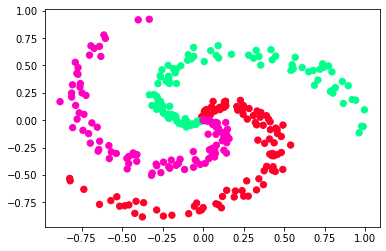

iteration 0: loss 1.098641
iteration 1000: loss 0.348202
iteration 2000: loss 0.263475
iteration 3000: loss 0.254516
iteration 4000: loss 0.249279
iteration 5000: loss 0.249247
iteration 6000: loss 0.248644
iteration 7000: loss 0.247696
iteration 8000: loss 0.246493
iteration 9000: loss 0.245901
training accuracy: 0.98


In [0]:

# https://blog.csdn.net/weixin_41090915/article/details/79521161
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

# 数据
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N * K, D)) # data matrix (each row = single example)
y = np.zeros(N * K, dtype='uint8') # class labels
for j in range(K):
    ix = list(range(N*j, N*(j + 1)))
    r = np.linspace(0.0, 1, N) # radius
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.gist_rainbow)
plt.show()
  
# 线性分类器
# gradient descent loop
# num_examples = X.shape[0]
# for i in range(200):

#     # evaluate class scores, [N x K]
#     scores = np.dot(X, W) + b 

#     # compute the class probabilities
#     exp_scores = np.exp(scores)
#     probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

#     # compute the loss: average cross-entropy loss and regularization
#     corect_logprobs = -np.log(probs[range(num_examples),y])
#     data_loss = np.sum(corect_logprobs)/num_examples
#     reg_loss = 0.5 * reg * np.sum(W * W)
#     loss = data_loss + reg_loss
#     if i % 10 == 0:
#         print ("iteration %d: loss %f" % (i, loss))

#     # compute the gradient on scores
#     dscores = probs
#     dscores[range(num_examples),y] -= 1
#     dscores /= num_examples

#     # backpropate the gradient to the parameters (W,b)
#     dW = np.dot(X.T, dscores)
#     db = np.sum(dscores, axis=0, keepdims=True)

#     dW += reg*W # regularization gradient

#     # perform a parameter update
#     W += -step_size * dW
#     b += -step_size * db


# BP神经网络

# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))  

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):

  # evaluate class scores, [N x K]
    hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
    scores = np.dot(hidden_layer, W2) + b2

    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5 * reg * np.sum(W * W) + 0.5 * reg * np.sum(W2 * W2)
    loss = data_loss + reg_loss
    if i % 1000 == 0:
        print("iteration %d: loss %f" % (i, loss))

    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0
    # finally into W,b
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)

    # add regularization gradient contribution
    dW2 += reg * W2
    dW += reg * W

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2

# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))



In [0]:
# -*- coding: utf-8 -*-
"""
last layer without sigmoid
@author: LYX
"""

import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))
def dsigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

class BP(object):
    def __init__(self, layers, activation='sigmoid', learning_rate=0.01):
      
    def forward(self, X):
    
    def backward(self, y):

    def compute_loss(self, y):
#%%
def test():
    
    
test()


In [0]:
from sklearn.datasets import load_boston
from sklearn import preprocessing
import torch

dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor

# 载入数据，并预处理
X, y = load_boston(return_X_y=True)
X = preprocessing.scale(X[:100, :])
y = preprocessing.scale(y[:100].reshape(-1, 1))

# 定义超参数
data_size, D_input, D_output, D_hidden = X.shape[0], X.shape[1], 1, 50
lr = 1e-5
epoch = 200000

# 转换为Tensor
# X = torch.Tensor(X).type(dtype)
# y = torch.Tensor(y).type(dtype)
X = torch.from_numpy(X).type(dtype)
y = torch.from_numpy(y).type(dtype)

# 定义训练参数
w1 = torch.randn(D_input, D_hidden).type(dtype)
w2 = torch.randn(D_hidden, D_output).type(dtype)

# 进行训练
for i in range(epoch):

    # 前向传播
    h = torch.mm(X, w1)  # 计算隐层
    h_relu = h.clamp(min=0)  # relu
    # y_pred = torch.mm(h_relu, w2)  # 输出层
    y_pred = h_relu.mm(w2) # 输出层

    # loss计算，使用L2损失函数
    loss = (y_pred - y).pow(2).sum()

    if i % 10000 == 0:
        print('epoch: {} loss: {:.4f}'.format(i, loss))

    # 反向传播，计算梯度
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = torch.mm(h_relu.t(), grad_y_pred)
    grad_h_relu = torch.mm(grad_y_pred, w2.t())

    # relu函数的倒数 右半段=1 左半段=0
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0

    grad_w1 = torch.mm(X.t(), grad_h)

    # 更新计算的梯度
    w1 -= lr * grad_w1
    w2 -= lr * grad_w2

In [0]:
import math
import random
import string

random.seed(0)

# 生成区间[a, b)内的随机数
def rand(a, b):
    return (b-a)*random.random() + a

# 生成大小 I*J 的矩阵，默认零矩阵 (当然，亦可用 NumPy 提速)
def makeMatrix(I, J, fill=0.0):
    m = []
    for i in range(I):
        m.append([fill]*J)
    return m

# 函数 sigmoid，这里采用 tanh，因为看起来要比标准的 1/(1+e^-x) 漂亮些
def sigmoid(x):
    return math.tanh(x)

# 函数 sigmoid 的派生函数, 为了得到输出 (即：y)
def dsigmoid(y):
    return 1.0 - y**2

class NN:
    ''' 三层反向传播神经网络 '''
    def __init__(self, ni, nh, no):
        # 输入层、隐藏层、输出层的节点（数）
        self.ni = ni + 1 # 增加一个偏差节点
        self.nh = nh
        self.no = no

        # 激活神经网络的所有节点（向量）
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no
        
        # 建立权重（矩阵）
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)
        # 设为随机值
        for i in range(self.ni):
            for j in range(self.nh):
                self.wi[i][j] = rand(-0.2, 0.2)
        for j in range(self.nh):
            for k in range(self.no):
                self.wo[j][k] = rand(-2.0, 2.0)

        # 最后建立动量因子（矩阵）
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)

    def update(self, inputs):
        if len(inputs) != self.ni-1:
            raise ValueError('与输入层节点数不符！')

        # 激活输入层
        for i in range(self.ni-1):
            #self.ai[i] = sigmoid(inputs[i])
            self.ai[i] = inputs[i]

        # 激活隐藏层
        for j in range(self.nh):
            sum = 0.0
            for i in range(self.ni):
                sum = sum + self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(sum)

        # 激活输出层
        for k in range(self.no):
            sum = 0.0
            for j in range(self.nh):
                sum = sum + self.ah[j] * self.wo[j][k]
            self.ao[k] = sigmoid(sum)

        return self.ao[:]

    def backPropagate(self, targets, N, M):
        ''' 反向传播 '''
        if len(targets) != self.no:
            raise ValueError('与输出层节点数不符！')

        # 计算输出层的误差
        output_deltas = [0.0] * self.no
        for k in range(self.no):
            error = targets[k]-self.ao[k]
            output_deltas[k] = dsigmoid(self.ao[k]) * error

        # 计算隐藏层的误差
        hidden_deltas = [0.0] * self.nh
        for j in range(self.nh):
            error = 0.0
            for k in range(self.no):
                error = error + output_deltas[k]*self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error

        # 更新输出层权重
        for j in range(self.nh):
            for k in range(self.no):
                change = output_deltas[k]*self.ah[j]
                self.wo[j][k] = self.wo[j][k] + N*change + M*self.co[j][k]
                self.co[j][k] = change
                #print(N*change, M*self.co[j][k])

        # 更新输入层权重
        for i in range(self.ni):
            for j in range(self.nh):
                change = hidden_deltas[j]*self.ai[i]
                self.wi[i][j] = self.wi[i][j] + N*change + M*self.ci[i][j]
                self.ci[i][j] = change

        # 计算误差
        error = 0.0
        for k in range(len(targets)):
            error = error + 0.5*(targets[k]-self.ao[k])**2
        return error

    def test(self, patterns):
        for p in patterns:
            print(p[0], '->', self.update(p[0]))

    def weights(self):
        print('输入层权重:')
        for i in range(self.ni):
            print(self.wi[i])
        print()
        print('输出层权重:')
        for j in range(self.nh):
            print(self.wo[j])

    def train(self, patterns, iterations=1000, N=0.5, M=0.1):
        # N: 学习速率(learning rate)
        # M: 动量因子(momentum factor)
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.update(inputs)
                error = error + self.backPropagate(targets, N, M)
            if i % 100 == 0:
                print('误差 %-.5f' % error)


def demo():
    # 一个演示：教神经网络学习逻辑异或（XOR）------------可以换成你自己的数据试试
    pat = [
        [[0,0], [0]],
        [[0,1], [1]],
        [[1,0], [1]],
        [[1,1], [0]]
    ]

    # 创建一个神经网络：输入层有两个节点、隐藏层有两个节点、输出层有一个节点
    n = NN(2, 2, 1)
    # 用一些模式训练它
    n.train(pat)
    # 测试训练的成果（不要吃惊哦）
    n.test(pat)
    # 看看训练好的权重（当然可以考虑把训练好的权重持久化）
    #n.weights()
    
    
if __name__ == '__main__':
    demo()

误差 0.94250
误差 0.04287
误差 0.00348
误差 0.00164
误差 0.00106
误差 0.00078
误差 0.00063
误差 0.00053
误差 0.00044
误差 0.00038
[0, 0] -> [0.00424108155062589]
[0, 1] -> [0.9821508029410748]
[1, 0] -> [0.9820129388618121]
[1, 1] -> [-0.0011469114721422528]
